In [1]:
SF = 10
ssd_cache    = False
result_cache = False
schema = f'CH{SF:02d}'

In [2]:
!pip install duckdb --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 90.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.0.0
    Uninstalling duckdb-1.0.0:
      Successfully uninstalled duckdb-1.0.0


**<mark><u>Import</u></mark>**

In [3]:
import duckdb
import pathlib
from   deltalake import convert_to_deltalake, DeltaTable
import time
import pandas as pd
from   deltalake.writer import write_deltalake
from   datetime import datetime
from   sqlglot import parse_one, exp
from   psutil import *
from   cachetools import cached, LRUCache

In [4]:
core=cpu_count()
core

2

# Generate Delta

In [5]:
%%time
Table_Path = '/lakehouse/default/Tables'
if not pathlib.Path(f'{Table_Path}/CH{SF:02d}').exists():
  for x in range(0, SF) :
    con=duckdb.connect()
    con.sql(f"CALL dbgen(sf={SF} , children ={SF}, step = {x})")
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
        pathlib.Path(f'{Table_Path}/CH{SF:02d}/{tbl}').mkdir(parents=True, exist_ok=True)
        con.sql(f"""  COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF:02d}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE,APPEND) """)
    con.close()
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      convert_to_deltalake(f'{Table_Path}/CH{SF:02d}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
else:
  print("Already Generated")

Already Generated
CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 198 ms


# SQL Query

In [6]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
	o_orderpriority,
	count(*) as order_count
from
	orders
where
	o_orderdate >= cast('1993-07-01' as date)
	and o_orderdate < cast('1993-10-01' as date)
	and o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		where
			l_commitdate < l_receiptdate
	)
group by
	o_orderpriority
order by
	o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
		p_brand = 'Brand#12'
		and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
		and l_quantity >= 1 and l_quantity <= 1 + 10
		and p_size between 1 and 5
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#23'
		and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
		and l_quantity >= 10 and l_quantity <= 10 + 10
		and p_size between 1 and 10
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#34'
		and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
		and l_quantity >= 20 and l_quantity <= 20 + 10
		and p_size between 1 and 15
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	);





--Query20
with availability_part_supp as(
	    select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
	    from lineitem
	    where l_shipdate >= cast('1994-01-01' as date)
	    and l_shipdate < cast('1995-01-01' as date)
	    group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
	    select ps_suppkey
	    from partsupp, availability_part_supp
	    where ps_partkey in (
		        select p_partkey
			        from part
				        where p_name like 'forest%'
					    )
					    and ps_partkey = pkey
					    and ps_suppkey = skey
					    and ps_availqty > ps_halfqty
				)
				and s_nationkey = n_nationkey
				and n_name = 'CANADA'
				order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
	count(*) as numcust,
	sum(c_acctbal) as totacctbal
from ( select
			substring(c_phone from 1 for 2) as cntrycode,
			c_acctbal
		from customer
		where substring(c_phone from 1 for 2) in
				('13', '31', '23', '29', '30', '18', '17')
			and c_acctbal > (
				select avg(c_acctbal)
				from customer
				where c_acctbal > 0
					and substring(c_phone from 1 for 2) in
						('13', '31', '23', '29', '30', '18', '17')
			)
			and c_custkey not in (
				select o_custkey
				from orders
			)
	) as custsale
group by cntrycode
order by cntrycode;

''')

# Utility Function

In [7]:
con = duckdb.connect(f'temp_CH{schema}.duckdb')
con.sql('SET preserve_insertion_order=false')
con.sql(""" create table if not exists delta(tbl string , version int,id string PRIMARY KEY) """)

In [8]:
def disk_cache(sql_query):
    if ssd_cache is True :
        tbl_type ='table'
    else:
        tbl_type ='view'
    print(tbl_type)
    start = time.time()
    data =[]
    tbl_list = [table.name for table in parse_one(sql_query).find_all(exp.Table)]
    for tbl in tbl_list :
            try :
                dt = DeltaTable(f'/lakehouse/default/Tables/{schema}/{tbl}')
                version =dt.version()
                table_id = dt.metadata().id
                data.append({'tbl': tbl, 'version': version,'id':table_id})
            except  Exception as er:
              print(f"this table is a CTE :{tbl}")         
    deltaonelake = pd.DataFrame(data)

    result =con.sql(" select tbl, version, id from deltaonelake where concat(id,cast (id as string))  not in (select concat(id,cast (id as string)) from delta)").fetchall()
    if len(result)==0:
        print ('all cacheed')
    else:
        for tbl, version, id in result:
            print(f"caching {tbl}")
            con.sql(f''' CREATE or replace {tbl_type}  {tbl} AS SELECT * FROM delta_scan('/lakehouse/default/Tables/{schema}/{tbl}') ''')
            con.sql(f''' INSERT OR REPLACE INTO delta VALUES ('{tbl}',{version}, '{id}'); ''')
            print(f"done")
        con.sql('checkpoint ;')
    print('cache to disk: ' + str(time.time()-start))
    return  ' '.join(deltaonelake.stack().astype(str))

In [9]:
if result_cache is True :
    @cached(cache=LRUCache(maxsize=32))
    def run_one_query(sql,metadata):
        return con.sql(sql).df()
else:
    def run_one_query(sql,metadata):
        return con.sql(sql).df()

In [10]:
def execute_multiplequery(sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            metadata = disk_cache(value)
            result = run_one_query(value,metadata)
            display(result)
            duration = time.time()-start
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

In [11]:
def duckdb_tpch(sql):
    df=execute_multiplequery(sql)
    df['Engine'] = 'duckdb'
    df['cache'] = ssd_cache
    df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf'] = SF
    df['cpu'] = core
    df['test'] = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/duckdbresult',df,mode="append",storage_options={"allow_unsafe_rename":"true"},engine='rust') 
    return "done"

# Run Tests

In [12]:
%%time
duckdb_tpch(sql)

Query1
view
caching lineitem
done
cache to disk: 2.0582351684570312


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

this table is a CTE :cheapest_part
caching part
done
caching partsupp
done
caching supplier
done
caching nation
done
caching region
done
caching part
done
caching partsupp
done
caching supplier
done
caching nation
done
caching region
done
cache to disk: 0.7637641429901123


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.555960655212402
Query3
view
caching customer
done
caching orders
done
cache to disk: 0.24761080741882324


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.425594329833984
Query4
view
all cacheed
cache to disk: 0.036374807357788086


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.3267104625701904
Query5
view
all cacheed
cache to disk: 0.10620641708374023


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

6.3797383308410645
Query6
view
all cacheed
cache to disk: 0.021868467330932617


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.4841489791870117
Query7
view
all cacheed
cache to disk: 0.10349750518798828


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.765747547149658
Query8
view
all cacheed
cache to disk: 0.1329352855682373


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

6.4856555461883545
Query9
view
all cacheed
cache to disk: 0.10619306564331055


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

8.53035593032837
Query10
view
all cacheed
cache to disk: 0.07485461235046387


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.467944860458374
Query11
view
all cacheed
cache to disk: 0.12146687507629395


1.4766829013824463
Query12
view
all cacheed
cache to disk: 0.04219675064086914


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.51965594291687
Query13
view
all cacheed
cache to disk: 0.03810882568359375


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.075577735900879
Query14
view
all cacheed
cache to disk: 0.03946113586425781


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.585115909576416
Query15
view
all cacheed
cache to disk: 0.3621044158935547


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.236835956573486
Query16
view
all cacheed
cache to disk: 0.06377124786376953


1.036365270614624
Query17
view
this table is a CTE :part_avg
all cacheed
cache to disk: 0.14969682693481445


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

8.58996844291687
Query18
view
all cacheed
cache to disk: 0.07460808753967285


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.29065203666687
Query19
view
all cacheed
cache to disk: 0.03601503372192383


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.427334547042847
Query20
view
this table is a CTE :availability_part_supp
all cacheed
cache to disk: 0.12776803970336914


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.672651767730713
Query21
view
all cacheed
cache to disk: 0.1783154010772705


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

20.88062024116516
Query22
view
all cacheed
cache to disk: 0.06797480583190918


1.4372198581695557
rr /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/_commit_89f21466-d844-4504-a72a-9b3a09c551c1.json.tmp -> /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/00000000000000000002.json
CPU times: user 3min 7s, sys: 15.7 s, total: 3min 23s
Wall time: 2min 26s


'done'

In [13]:
%%time
duckdb_tpch(sql)

Query1
view
all cacheed
cache to disk: 0.023409366607666016


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

this table is a CTE :cheapest_part
all cacheed
cache to disk: 0.3124978542327881


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.675918817520142
Query3
view
all cacheed
cache to disk: 0.0925602912902832


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.155829668045044
Query4
view
all cacheed
cache to disk: 0.041908979415893555


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.3603270053863525
Query5
view
all cacheed
cache to disk: 0.09962630271911621


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

6.550163269042969
Query6
view
all cacheed
cache to disk: 0.018604040145874023


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.5773422718048096
Query7
view
all cacheed
cache to disk: 0.10258007049560547


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.88286828994751
Query8
view
all cacheed
cache to disk: 0.15027332305908203


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.0651304721832275
Query9
view
all cacheed
cache to disk: 0.10631251335144043


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

8.54647946357727
Query10
view
all cacheed
cache to disk: 0.38164615631103516


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.797818422317505
Query11
view
all cacheed
cache to disk: 0.10492897033691406


1.4335551261901855
Query12
view
all cacheed
cache to disk: 0.03994345664978027


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.707802057266235
Query13
view
all cacheed
cache to disk: 0.037114858627319336


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.22629714012146
Query14
view
all cacheed
cache to disk: 0.04365897178649902


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3.511991262435913
Query15
view
all cacheed
cache to disk: 0.05527520179748535


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

6.720840930938721
Query16
view
all cacheed
cache to disk: 0.0666360855102539


1.0965802669525146
Query17
view
this table is a CTE :part_avg
all cacheed
cache to disk: 0.06474590301513672


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

8.940246820449829
Query18
view
all cacheed
cache to disk: 0.1445903778076172


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

7.644203186035156
Query19
view
all cacheed
cache to disk: 0.0389857292175293


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.891578674316406
Query20
view
this table is a CTE :availability_part_supp
all cacheed
cache to disk: 0.09769892692565918


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5.722201347351074
Query21
view
all cacheed
cache to disk: 0.10867738723754883


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

26.08358860015869
Query22
view
all cacheed
cache to disk: 0.09675765037536621


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4.003516435623169
rr /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/_commit_42f8978d-521e-498d-9be2-178062520b65.json.tmp -> /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/00000000000000000003.json
CPU times: user 3min 9s, sys: 17.7 s, total: 3min 27s
Wall time: 2min 26s


'done'

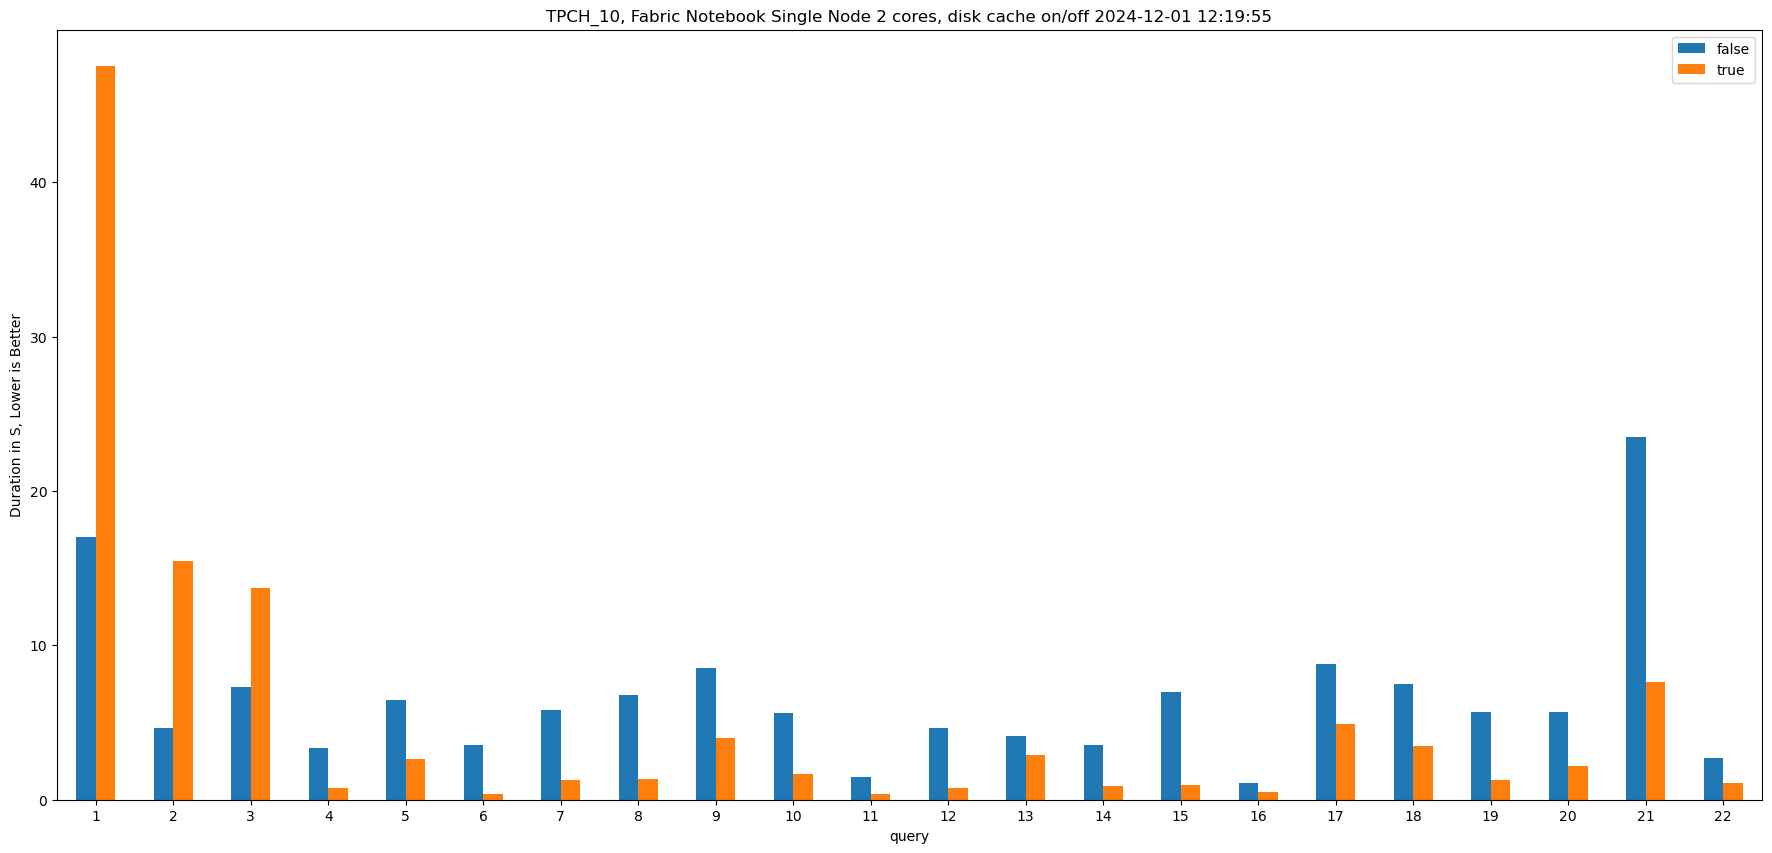

In [14]:
pv = duckdb.sql(f"""PIVOT ( select cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch') ON cache using avg(dur) order by query""")
xx = duckdb.sql(f" select query, sum(COLUMNS(*exclude(sf,query))) from pv  group by all order by query  ").df()
ax = xx.plot.bar(rot=0,x='query',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'),ylabel='Duration in S, Lower is Better',figsize=(22,10))

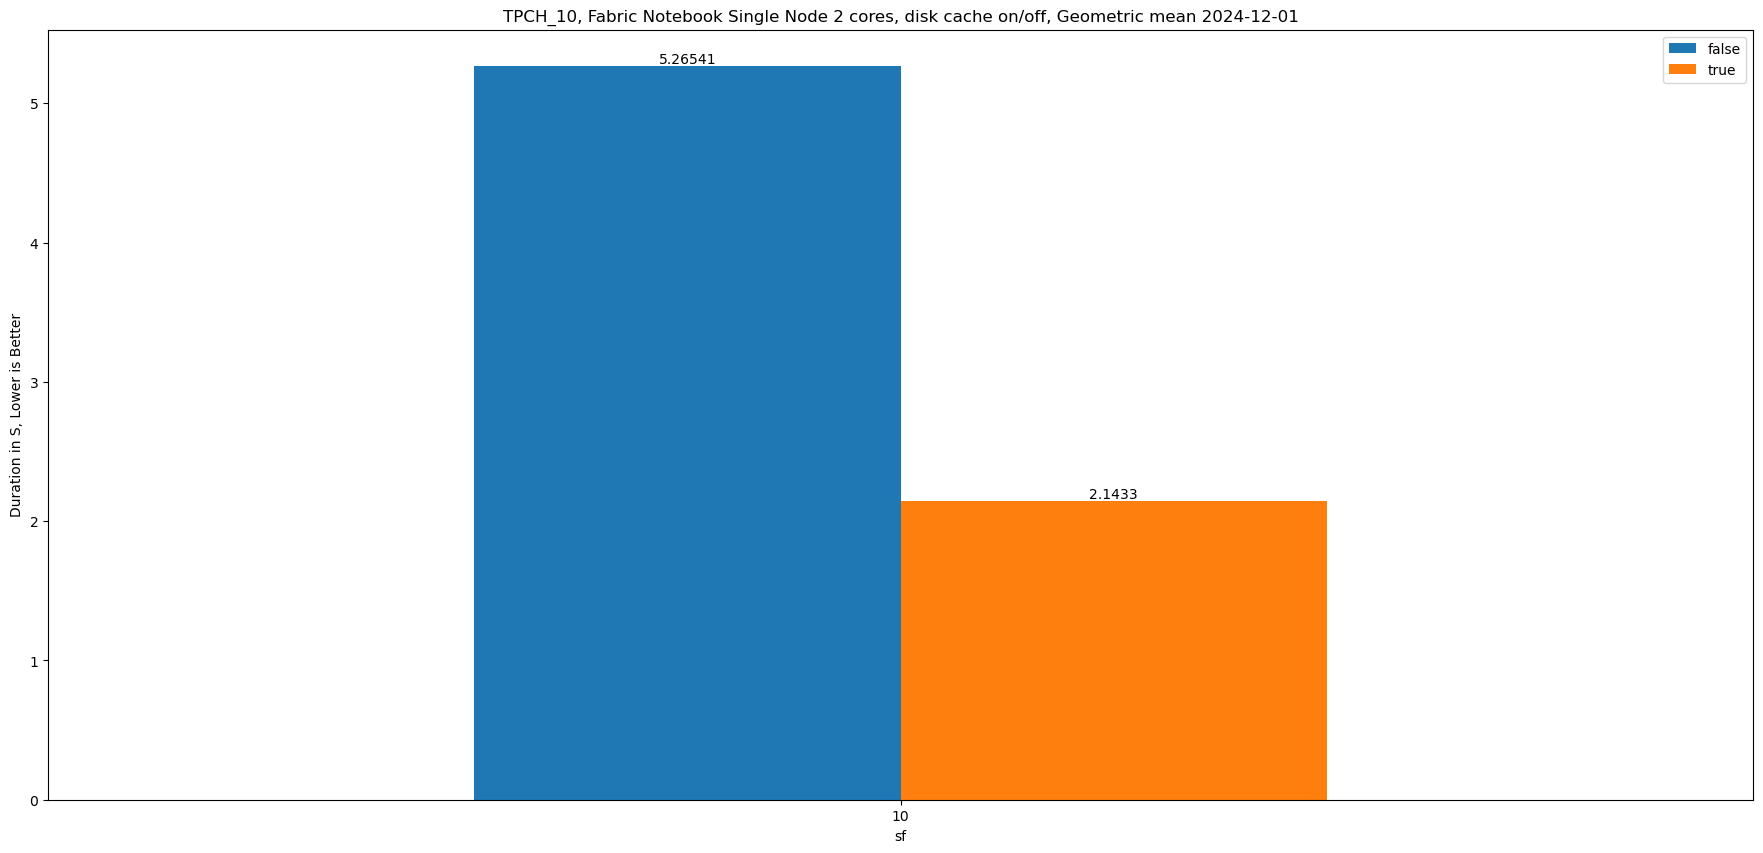

In [17]:
pv = duckdb.sql(f"""PIVOT ( select cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON cache using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, geomean(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off, Geometric mean " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

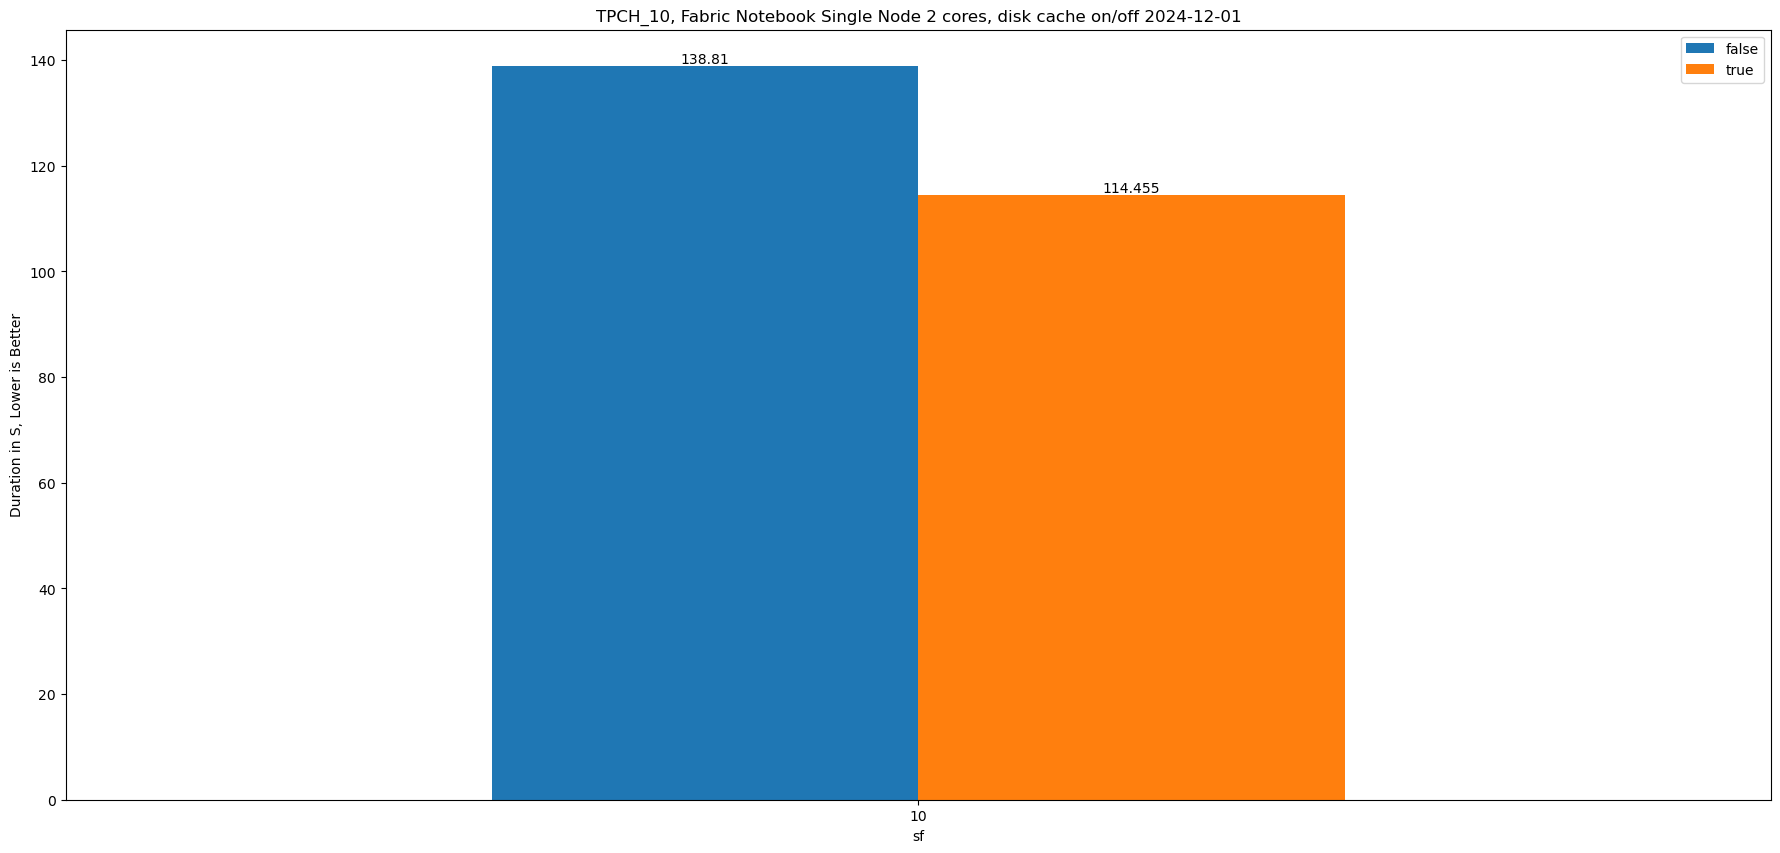

In [18]:
pv = duckdb.sql(f"""PIVOT ( select cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON cache using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, sum(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')